In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [2]:
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [2, 0]] / 10.0 * np.array([1, -1])


class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim), nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(), nn.Linear(hidden_dim, data_dim * 2)
                                                         ) for _ in range(N)])

    def forward(self, x, t: int):
        h = self.network_head(x)
        return self.network_tail[t](h)


class DiffusionModel(nn.Module):

    def __init__(self, model: nn.Module, n_steps=40, device='cuda'):
        super().__init__()

        self.model = model
        self.device = device

        betas = torch.linspace(-18, 10, n_steps)
        self.beta = torch.sigmoid(betas) * (3e-1 - 1e-5) + 1e-5

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def forward_process(self, x0, t):

        t = t - 1  # Start indexing at 0
        beta_forward = self.beta[t]
        alpha_forward = self.alpha[t]
        alpha_cum_forward = self.alpha_bar[t]
        xt = x0 * torch.sqrt(alpha_cum_forward) + torch.randn_like(x0) * torch.sqrt(1. - alpha_cum_forward)
        # Retrieved from https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models/blob/master/model.py#L203
        mu1_scl = torch.sqrt(alpha_cum_forward / alpha_forward)
        mu2_scl = 1. / torch.sqrt(alpha_forward)
        cov1 = 1. - alpha_cum_forward / alpha_forward
        cov2 = beta_forward / alpha_forward
        lam = 1. / cov1 + 1. / cov2
        mu = (x0 * mu1_scl / cov1 + xt * mu2_scl / cov2) / lam
        sigma = torch.sqrt(1. / lam)
        return mu, sigma, xt

    def reverse(self, xt, t):

        t = t - 1  # Start indexing at 0
        if t == 0: return None, None, xt
        mu, h = self.model(xt, t).chunk(2, dim=1)
        sigma = torch.sqrt(torch.exp(h))
        samples = mu + torch.randn_like(xt) * sigma
        return mu, sigma, samples

    def sample(self, size, device):
        noise = torch.randn((size, 2)).to(device)
        samples = [noise]
        for t in range(self.n_steps):
            _, _, x = self.reverse(samples[-1], self.n_steps - t - 1 + 1)
            samples.append(x)
        return samples


def plot(model):
    plt.figure(figsize=(10, 6))
    x0 = sample_batch(5000)
    x20 = model.forward_process(torch.from_numpy(x0).to(device), 20)[-1].data.cpu().numpy()
    x40 = model.forward_process(torch.from_numpy(x0).to(device), 40)[-1].data.cpu().numpy()
    data = [x0, x20, x40]
    for i, t in enumerate([0, 20, 39]):
        plt.subplot(2, 3, 1 + i)
        plt.scatter(data[i][:, 0], data[i][:, 1], alpha=.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=17)
        if i == 2: plt.title(r'$t=T$', fontsize=17)

    samples = model.sample(5000, device)
    for i, t in enumerate([0, 20, 40]):
        plt.subplot(2, 3, 4 + i)
        plt.scatter(samples[40 - t][:, 0].data.cpu().numpy(), samples[40 - t][:, 1].data.cpu().numpy(),
                    alpha=.1, s=1, c='r')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
    # plt.savefig(f"Imgs/diffusion_model.png", bbox_inches='tight')
    plt.close()
 


In [3]:
device = 'cuda'
n_steps=100


model_mlp = MLP(hidden_dim=128, N=n_steps).to(device)
model = DiffusionModel(model_mlp, n_steps=n_steps)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-4)
# train(model, optimizer)


In [4]:
nb_epochs=150_000
batch_size=64_000


training_loss = []
for _ in tqdm(range(nb_epochs)):
    x0 = torch.from_numpy(sample_batch(batch_size)).float().to(device)
    t = np.random.randint(2, n_steps + 1)
    mu_posterior, sigma_posterior, xt = model.forward_process(x0, t)
    mu, sigma, _ = model.reverse(xt, t)

    KL = (torch.log(sigma) - torch.log(sigma_posterior) + (sigma_posterior ** 2 + (mu_posterior - mu) ** 2) / (
            2 * sigma ** 2) - 0.5)
    loss = KL.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())

100%|██████████| 150000/150000 [18:32<00:00, 134.88it/s]


In [6]:
plot(model)

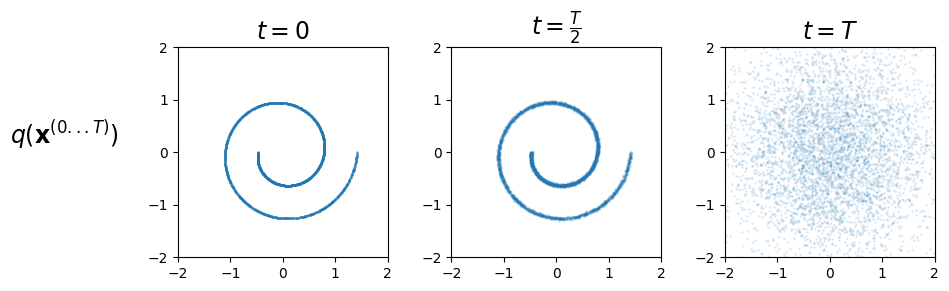

In [9]:
plt.figure(figsize=(10, 6))
x0 = sample_batch(5000)
x20 = model.forward_process(torch.from_numpy(x0).to(device), 20)[-1].data.cpu().numpy()
x40 = model.forward_process(torch.from_numpy(x0).to(device), 100)[-1].data.cpu().numpy()
data = [x0, x20, x40]
for i, t in enumerate([0, 20, 39]):
    plt.subplot(2, 3, 1 + i)
    plt.scatter(data[i][:, 0], data[i][:, 1], alpha=.1, s=1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')
    if t == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
    if i == 0: plt.title(r'$t=0$', fontsize=17)
    if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=17)
    if i == 2: plt.title(r'$t=T$', fontsize=17)

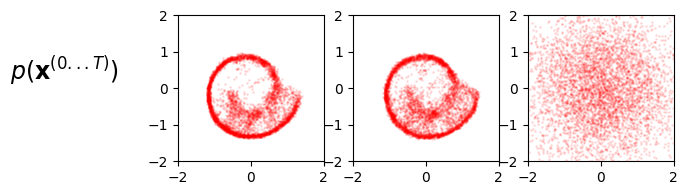

In [10]:
samples = model.sample(5000, device)
for i, t in enumerate([0, 20, 100]):
    plt.subplot(2, 3, 4 + i)
    plt.scatter(samples[100 - t][:, 0].data.cpu().numpy(), samples[100 - t][:, 1].data.cpu().numpy(),
                alpha=.1, s=1, c='r')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')
    if t == 0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)